In [1]:
from pathlib import Path  
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataframe = pandas.read_csv("dataset.csv").dropna()
dataframe["date"] = pandas.to_datetime(dataframe['date'], format='%Y-%m-%d %H:%M:%S')
dataframe["NSM"] = (dataframe["date"] - pandas.to_datetime(dataframe['date'].dt.date, format='%Y-%m-%d')).dt.total_seconds()
dataframe["week_status"] = dataframe["date"].apply(lambda date: 1 if(date.weekday() <= 4) else 0)
dataframe["day_of_monday"] = dataframe["date"].apply(lambda date: date.weekday() == 0)
dataframe["day_of_tuesday"] = dataframe["date"].apply(lambda date: date.weekday() == 1)
dataframe["day_of_wednesday"] = dataframe["date"].apply(lambda date: date.weekday() == 2)
dataframe["day_of_thursday"] = dataframe["date"].apply(lambda date: date.weekday() == 3)
dataframe["day_of_friday"] = dataframe["date"].apply(lambda date: date.weekday() == 4)
dataframe["day_of_saturday"] = dataframe["date"].apply(lambda date: date.weekday() == 5)
dataframe["day_of_sunday"] = dataframe["date"].apply(lambda date: date.weekday() == 6)
dataframe = dataframe.drop("date", axis = 1).dropna()
dataframe.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,rv2,NSM,week_status,day_of_monday,day_of_tuesday,day_of_wednesday,day_of_thursday,day_of_friday,day_of_saturday,day_of_sunday
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,13.275433,61200.0,1,True,False,False,False,False,False,False
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.606195,61800.0,1,True,False,False,False,False,False,False
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,28.642668,62400.0,1,True,False,False,False,False,False,False
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.410389,63000.0,1,True,False,False,False,False,False,False
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,10.084097,63600.0,1,True,False,False,False,False,False,False


In [3]:
X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]
TEST_SIZE_RATIO = 0.20
RANDOM_STATE_SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

In [4]:
FORCE_TRAIN_MODEL = True
GBR_metrics_dataset_PATH = Path("./GBR_metrics_dataset.csv")
GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH = Path("./GBR_releative_feature_importance_dataset.csv")
if FORCE_TRAIN_MODEL or not (GBR_metrics_dataset_PATH.exists() and GBR_metrics_dataset_PATH.is_file()):
    N_ESTIMATORS = 1000
    MAX_DEPTH_SET = [1, 2, 3]
    performance = {}
    for max_depth_iterator in MAX_DEPTH_SET:
        print("\nTraining Gradient Boosted Regression Model for MAX_DEPTH: %d" %max_depth_iterator)
        # Applying Gradient Boosting Regression model to the dataset.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
        gradient_boosting_regressor = GradientBoostingRegressor(n_estimators = N_ESTIMATORS, max_depth = max_depth_iterator, verbose = 1)
        gradient_boosting_regressor.fit(X_train, y_train)

        # Calculate the metrics for the model.
        # Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
        performance[max_depth_iterator] = {}
        for ilteration, y_pred in enumerate(gradient_boosting_regressor.staged_predict(X)):
            performance[max_depth_iterator][ilteration + 1] = {
                "training_loss": gradient_boosting_regressor.loss_(y, y_pred),
                "root_mean_square_error": mean_squared_error(y, y_pred, squared=False),
                "r2_score": r2_score(y, y_pred),
                "mean_absolute_error": mean_absolute_error(y, y_pred),
                "mean_absolute_percentage_error": mean_absolute_percentage_error(y, y_pred)
            }
    
    # Save the calculated metrics of the Gradient Boosting Regression Model into the csv.
    csv_string = "\"max_depth\",\"iteration\",\"training_loss\",\"root_mean_square_error\",\"r2_score\",\"mean_absolute_error\",\"mean_absolute_percentage_error\""
    for depth in performance.keys():
        for iteration in numpy.arange(1, len(performance[depth]) + 1):
            csv_string = csv_string + "\n" + str(depth) + "," + str(iteration) + "," + str(performance[depth][iteration]["training_loss"]) + "," + str(performance[depth][iteration]["root_mean_square_error"]) + "," + str(performance[depth][iteration]["r2_score"]) + "," + str(performance[depth][iteration]["mean_absolute_error"]) + "," + str(performance[depth][iteration]["mean_absolute_percentage_error"])
    gradient_boosted_graph_metrics_dataset = open(GBR_metrics_dataset_PATH.name, "w")
    gradient_boosted_graph_metrics_dataset.write(csv_string)
    gradient_boosted_graph_metrics_dataset.close()

    # Save the importance of the feature w.r.t the most important feature and store the data into csv.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.feature_importances_
    feature_importance = gradient_boosting_regressor.feature_importances_
    releative_feature_importance = (feature_importance / feature_importance.max()) * 100
    sorted_indices=numpy.argsort(releative_feature_importance)
    pandas.DataFrame(data = {"feature_names": X.columns[sorted_indices], "releative_feature_importance": releative_feature_importance[sorted_indices], "feature_importance": feature_importance[sorted_indices]}).to_csv(GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)


Training Gradient Boosted Regression Model for MAX_DEPTH: 1
      Iter       Train Loss   Remaining Time 
         1       10221.7201           58.64s
         2       10085.5847           56.90s
         3        9975.3051           53.75s
         4        9885.1927           50.82s
         5        9811.6228           48.91s
         6        9749.9519           48.09s
         7        9692.3731           47.57s
         8        9644.7444           46.59s
         9        9599.6174           45.77s
        10        9560.2494           45.20s
        20        9263.6210           40.45s
        30        9090.3992           44.47s
        40        8972.4026           45.22s
        50        8886.4634           43.17s
        60        8816.0895           41.16s
        70        8758.4507           39.97s
        80        8709.0516           40.29s
        90        8665.1536           39.29s
       100        8625.3686           39.42s
       200        8343.2612           

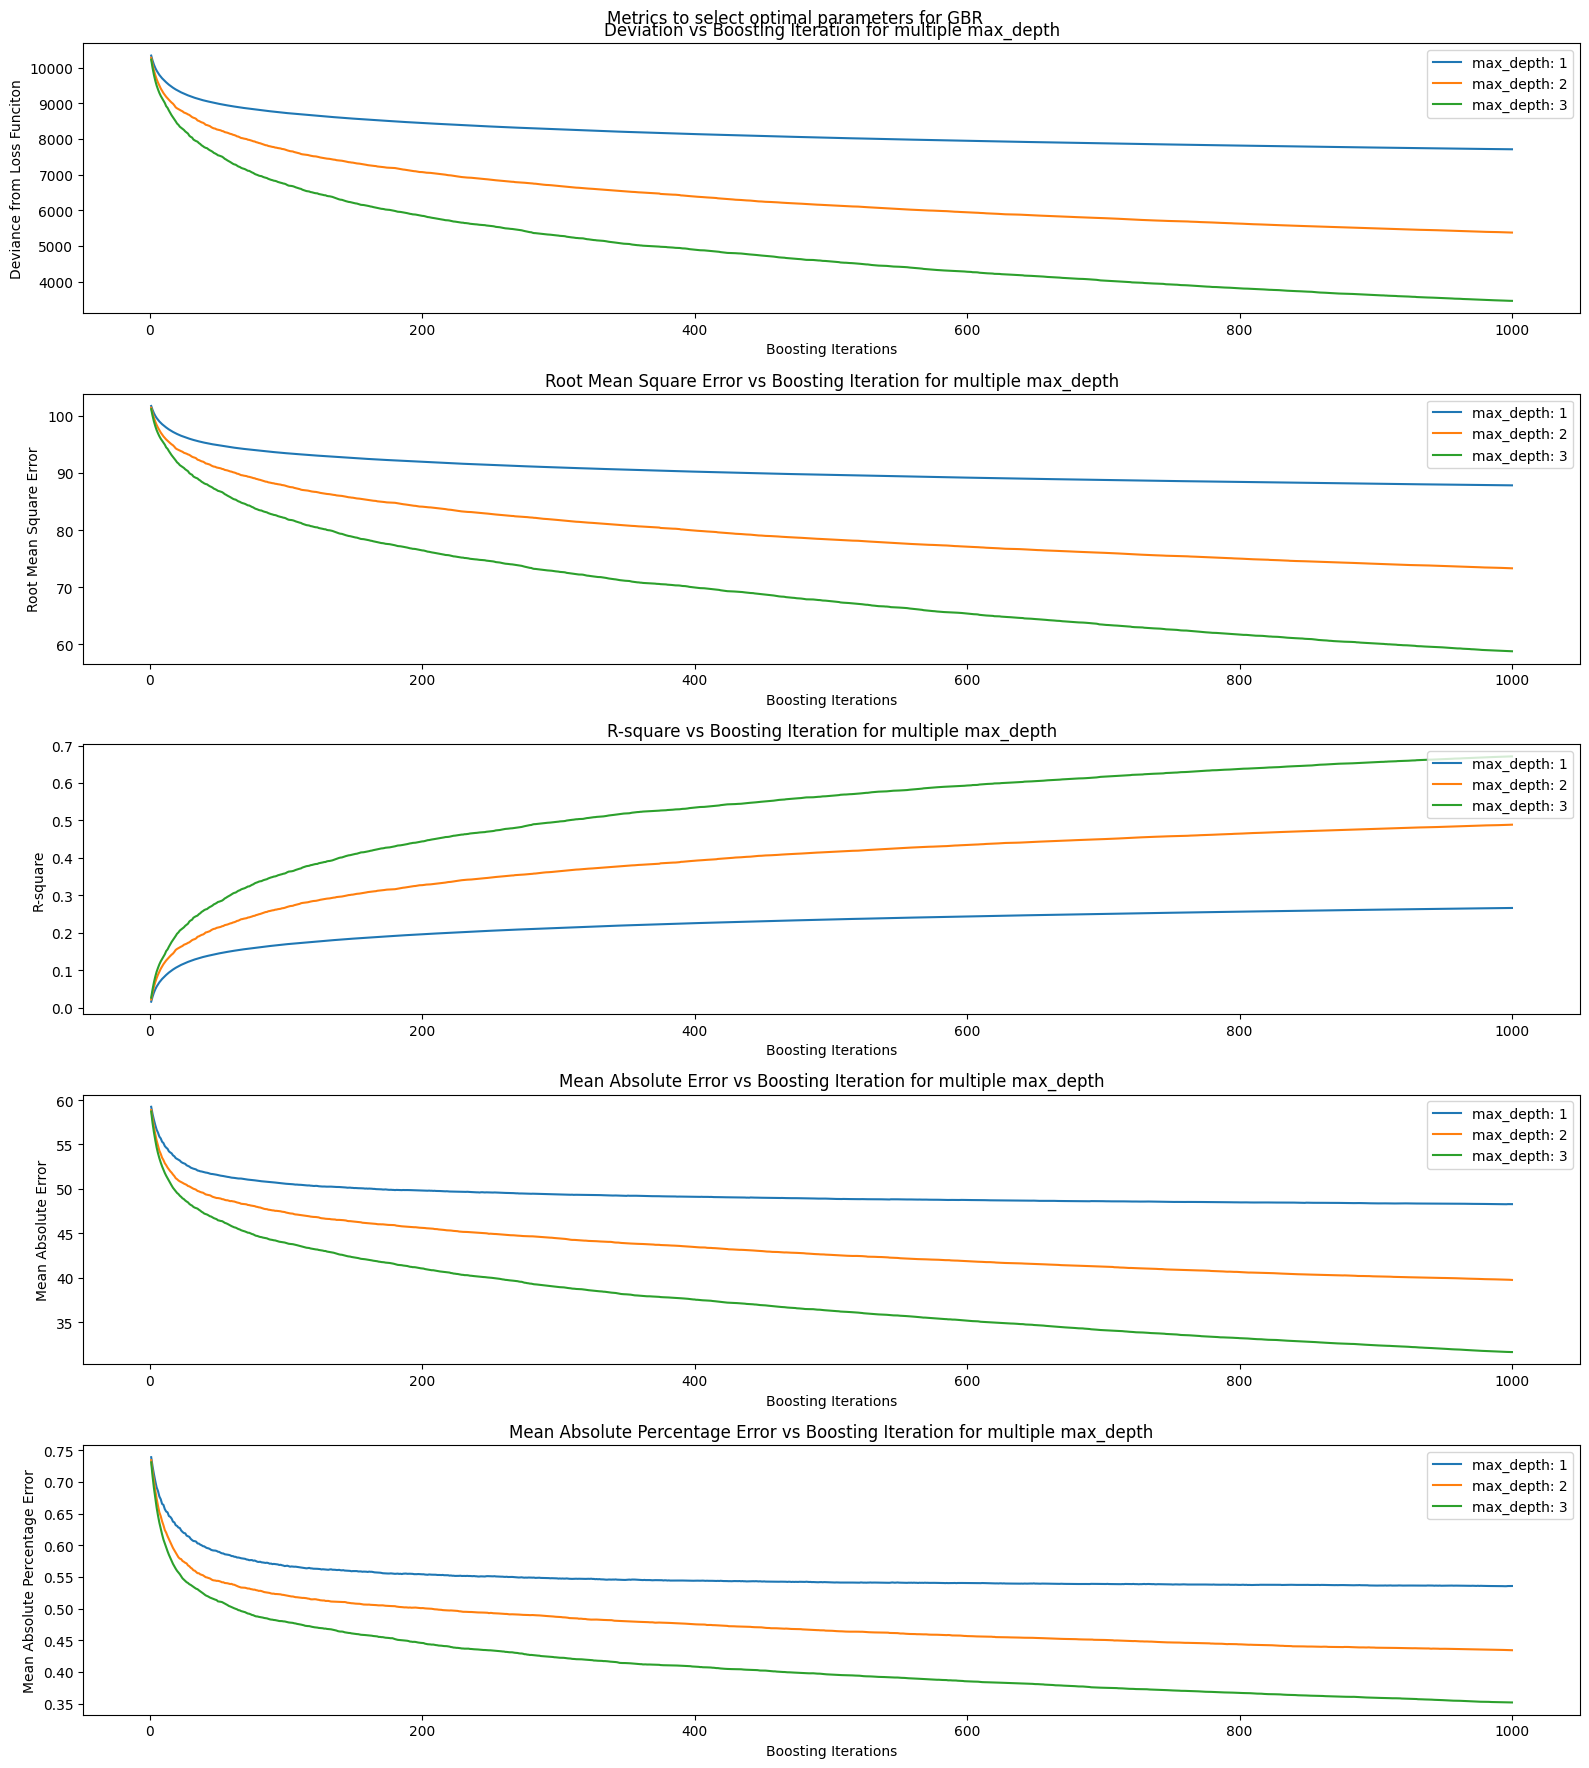

In [7]:
# Visualize model's metrics using line graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
gbr_metrics = pandas.read_csv(GBR_metrics_dataset_PATH.name)
figure, (plot1, plot2, plot3, plot4, plot5) = plot.subplots(5)
plot.tight_layout()

plot1.set_title("Deviation vs Boosting Iteration for multiple max_depth")
plot1.set_xlabel('Boosting Iterations')
plot1.set_ylabel('Deviance from Loss Funciton')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot1.plot(performance["iteration"], performance["training_loss"], label = "max_depth: "  + str(depth))
plot1.legend(loc='upper right')

plot2.set_title("Root Mean Square Error vs Boosting Iteration for multiple max_depth")
plot2.set_xlabel('Boosting Iterations')
plot2.set_ylabel('Root Mean Square Error')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot2.plot(performance["iteration"], performance["root_mean_square_error"], label = "max_depth: "  + str(depth))
plot2.legend(loc='upper right')

plot3.set_title("R-square vs Boosting Iteration for multiple max_depth")
plot3.set_xlabel('Boosting Iterations')
plot3.set_ylabel('R-square')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot3.plot(performance["iteration"], performance["r2_score"], label = "max_depth: "  + str(depth))
plot3.legend(loc='upper right')

plot4.set_title("Mean Absolute Error vs Boosting Iteration for multiple max_depth")
plot4.set_xlabel('Boosting Iterations')
plot4.set_ylabel('Mean Absolute Error')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot4.plot(performance["iteration"], performance["mean_absolute_error"], label = "max_depth: "  + str(depth))
plot4.legend(loc='upper right')

plot5.set_title("Mean Absolute Percentage Error vs Boosting Iteration for multiple max_depth")
plot5.set_xlabel('Boosting Iterations')
plot5.set_ylabel('Mean Absolute Percentage Error')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot5.plot(performance["iteration"], performance["mean_absolute_percentage_error"], label = "max_depth: "  + str(depth))
plot5.legend(loc='upper right')

figure.set_figheight(18)
figure.set_figwidth(16)
figure.suptitle("Metrics to select optimal parameters for GBR")
figure.tight_layout()
figure.savefig("GBR_metrics_vs_iteration_for_multiple_max_depth.png")
figure.show()

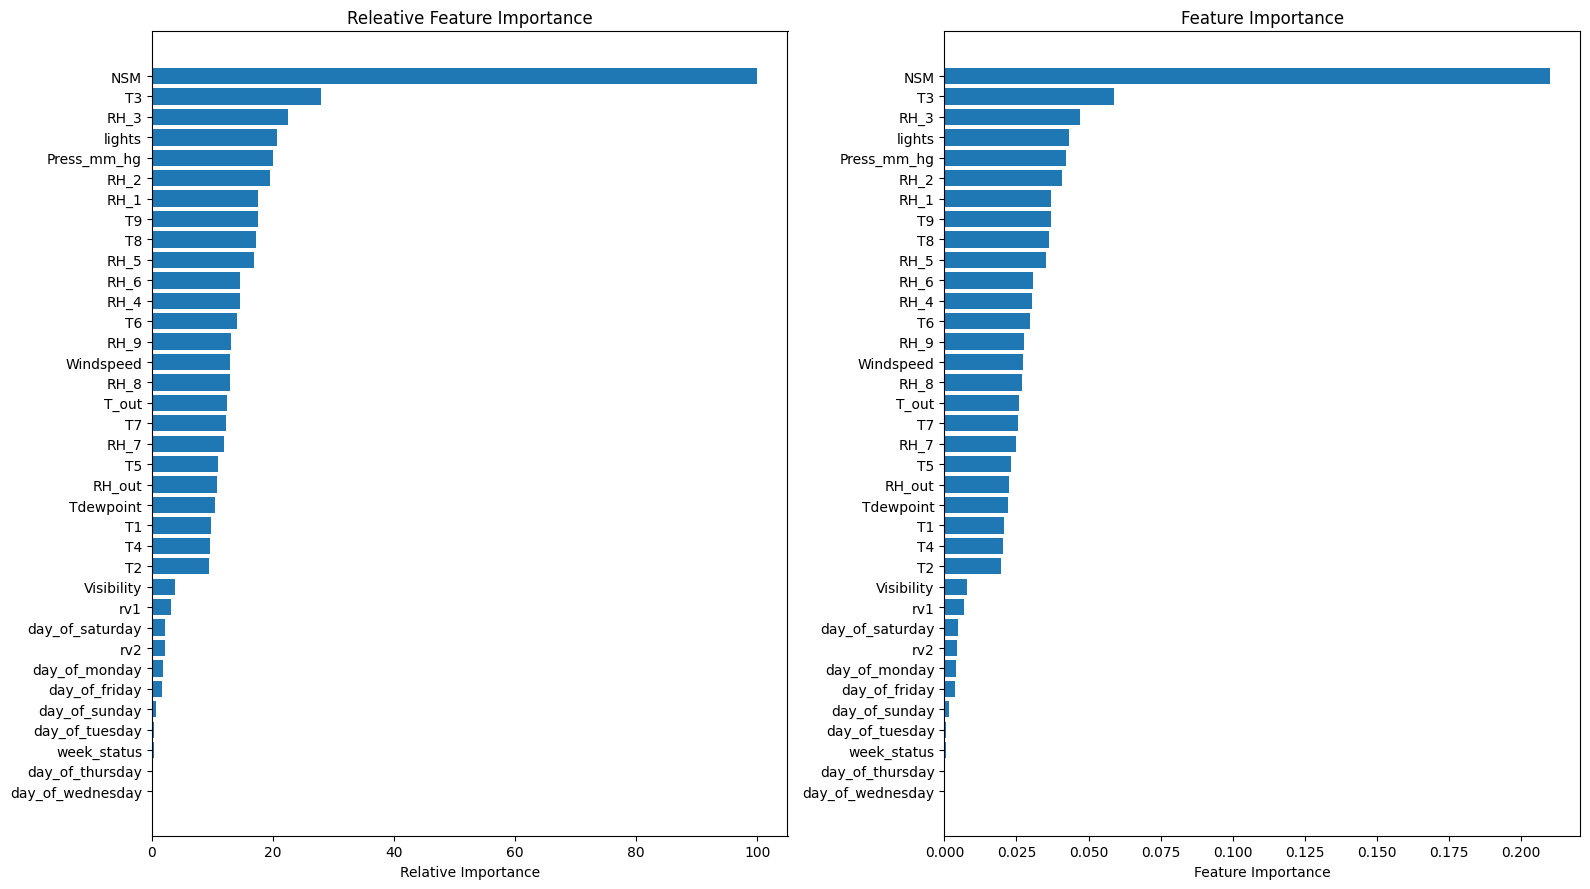

In [8]:
# Visualize feature importance of the model using bar graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
gbr_metrics = pandas.read_csv(GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)

figure, (plot1, plot2) = plot.subplots(1, 2)

plot1.barh(gbr_metrics["feature_names"], gbr_metrics["releative_feature_importance"], align="center")
plot1.set_xlabel('Relative Importance')
plot1.set_title('Releative Feature Importance')

plot2.barh(gbr_metrics["feature_names"], gbr_metrics["feature_importance"], align="center")
plot2.set_xlabel('Feature Importance')
plot2.set_title('Feature Importance')

figure.set_figheight(9)
figure.set_figwidth(16)
figure.tight_layout()
figure.savefig("GBR_feature_importance.png")
figure.show()
